In [1]:
#imports
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from helpers.products import Products
from directed_graph_generators.directed_tree import DirectedTree
from directed_graph_generators.lattice import DirectedLattice
from directed_graph_generators.directed_stochastic_block_model import DirectedStochasticBlockModel
from directed_graph_generators.directed_erdos_renyi import DirectedErdosRenyi

from clustering_algorithms.exponential_clustering import Exponential_Clustering, Exponential_Clustering_no_evecs
from clustering_algorithms.zanetti_clustering import DSBM_Clustering_Zanetti

from helpers.get_hermitian_adjacency_matrix import get_hermitian_adjacency_matrix
from helpers.deduce_metagraph import deduce_metagraph

In [2]:
# make a 4 cycle directed stochastic block model
F = np.array([[0.5,1.0,0.5,0.0],
              [0.5,0.5,1.0,0.5],
              [0.5,0.5,0.5,1.0],
              [1.0,0.5,0.5,0.5]])
A = DirectedStochasticBlockModel(4,400,1,1,F).adjacency_matrix

<AxesSubplot: >

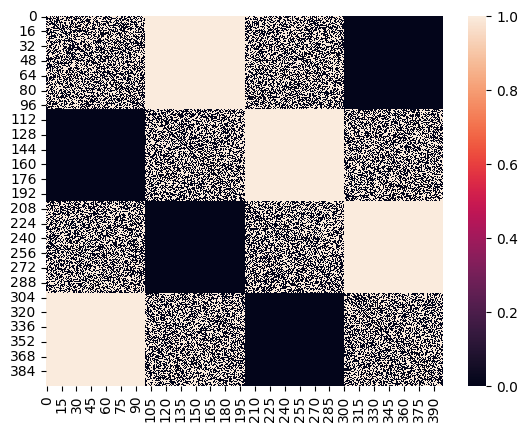

In [3]:
sns.heatmap(A)

In [4]:
clusters = [[i for i in range(100)], [i for i in range(100,200)], [i for i in range(200,300)], [i for i in range(300,400)]]
M = deduce_metagraph(A, clusters, normalize=True)

In [5]:
get_hermitian_adjacency_matrix(M,normalize=False)

array([[ 0.+0.j        ,  0.+0.25062657j,  0.+0.j        ,
        -0.-0.25062657j],
       [-0.-0.25062657j,  0.+0.j        ,  0.+0.25062657j,
         0.+0.j        ],
       [ 0.+0.j        , -0.-0.25062657j,  0.+0.j        ,
         0.+0.25062657j],
       [ 0.+0.25062657j,  0.+0.j        , -0.-0.25062657j,
         0.+0.j        ]])

In [35]:
def upper_bound_and_true_difference(A,M,l,clusters):
    """ A - adjacency matrix of graph
        M - metagraph of graph
       l - index of last informative eigenvalue/eigenvector
       clusters - list of lists of vertices in each cluster. We use this to construct \bar{g}_l
    Returns: 
    norm of difference between lth eigenvector of L_A and L_M
    and \gamma_l / \lambda_{l+1}
    """
    #getting A_herm
    A_herm = get_hermitian_adjacency_matrix(A,normalize=True)
    # getting D to create indicator vectors
    D_half = np.zeros(A_herm.shape)
    A_sym = A + A.T
    np.fill_diagonal(D_half,[np.sqrt(d) for d in np.sum(np.abs(A_sym), axis=1) if d != 0])
    # getting L_A and L_M
    M_herm = get_hermitian_adjacency_matrix(M,normalize=False)
    L_A = np.eye(A.shape[0]) - A_herm
    L_M = np.eye(M.shape[0]) - M_herm
    # compute eigenvectors of L_A and obtain f
    eigvals, eigvecs = np.linalg.eig(L_A)
    eigvals = np.real(eigvals)
    idx_A = eigvals.argsort()
    eigvals = eigvals[idx_A]
    eigvecs = eigvecs[:,idx_A]
    f = eigvecs[:,l]
    # normalize f
    f = f/np.linalg.norm(f)
    # compute eigenvectors of L_M and obtain g
    meta_eigvals, meta_eigvecs = np.linalg.eig(L_M)
    meta_eigvals = np.real(meta_eigvals)
    idx_M = meta_eigvals.argsort()
    meta_eigvals = meta_eigvals[idx_M]
    meta_eigvecs = meta_eigvecs[:,idx_M]
    
    g_bar = np.zeros(f.shape, dtype=np.complex_)
    # compute \bar{g}
    for k in range(l+1):
        g = meta_eigvecs[:,k]
        g_bar_k = np.zeros(f.shape, dtype=np.complex_)

        for i in range(len(clusters)):
            # define complex indicator vector
            indicator = np.zeros(f.shape,dtype=np.complex_)
            indicator[clusters[i]] = 1 + 0j
            indicator = D_half @ indicator
            #normalize
            indicator = indicator/np.linalg.norm(indicator)
            g_bar_k[clusters[i]] = g[i]*indicator[clusters[i]]
        print(np.linalg.norm(g_bar_k))
        g_bar += np.vdot(g_bar_k,f)*g_bar_k
        print(np.vdot(g_bar_k,f))
    #g_bar = g_bar/np.linalg.norm(g_bar)
    norm_diff = np.linalg.norm(f-g_bar)
    gamma_l = meta_eigvals[l]
    lambda_l_plus_1 = eigvals[l+1]
    return norm_diff**2, gamma_l, lambda_l_plus_1


In [30]:
norm_squared, gamma_1, lambda_2 = upper_bound_and_true_difference(A,M,1,clusters)

1.0
(-0.0016686324517677972+0.0021226761764250794j)


In [37]:
#4 cycle again with smaller p and q
F = np.array([[0.5,1.0,0.5,0.0],
              [0.5,0.5,1.0,0.5],
              [0.5,0.5,0.5,1.0],
              [1.0,0.5,0.5,0.5]])
A = DirectedStochasticBlockModel(4,400,0.5,0.5,F).adjacency_matrix
clusters = [[i for i in range(100)], [i for i in range(100,200)], [i for i in range(200,300)], [i for i in range(300,400)]]
M = deduce_metagraph(A, clusters, normalize=True)

norm_squared, gamma_1, lambda_2 = upper_bound_and_true_difference(A,M,0,clusters)
print("actual difference squared:", norm_squared)
print(r"$gamma_1$" + ":", gamma_1)
print(r"$lambda_2$" + ":", lambda_2)
print('ratio:', gamma_1/lambda_2)


0.9999999999999998
(0.023720194646257-0.9925708572869264j)
actual difference squared: 0.014240445630639576
$gamma_1$: 0.5527652283556496
$lambda_2$: 0.8814546766587914
ratio: 0.627105673148097


In [38]:
#different structure
F = np.array([[0.5,1.0,1.0,1.0],
              [0.0,0.5,1.0,0.5],
              [0.0,0.5,0.5,1.0],
              [0.0,0.5,0.5,0.5]])
A = DirectedStochasticBlockModel(4,400,0.05,0.05,F).adjacency_matrix
clusters = [[i for i in range(100)], [i for i in range(100,200)], [i for i in range(200,300)], [i for i in range(300,400)]]
M = deduce_metagraph(A, clusters, normalize=True)

norm_squared, gamma_1, lambda_2 = upper_bound_and_true_difference(A,M,0,clusters)
print("actual difference squared:", norm_squared)
print(r"$gamma_1$" + ":", gamma_1)
print(r"$lambda_2$" + ":", lambda_2)
print('ratio:', gamma_1/lambda_2)

0.9999999999999998
(-0.32914415199604385+0.8470132522475444j)
actual difference squared: 0.17423267772384268
$gamma_1$: 0.5819083126025026
$lambda_2$: 0.615019488576488
ratio: 0.9461623955191666


In [41]:
#different structure
F = np.array([[0.5,1.0,1.0,1.0],
              [0.0,0.5,1.0,0.5],
              [0.0,0.5,0.5,1.0],
              [0.0,0.5,0.5,0.5]])
A = DirectedStochasticBlockModel(4,400,0.05,0.05,F).adjacency_matrix
clusters = [[i for i in range(100)], [i for i in range(100,200)], [i for i in range(200,300)], [i for i in range(300,400)]]
M = deduce_metagraph(A, clusters, normalize=True)

norm_squared, gamma_1, lambda_2 = upper_bound_and_true_difference(A,M,0,clusters)
print("actual difference squared:", norm_squared)
print(r"$gamma_1$" + ":", gamma_1)
print(r"$lambda_2$" + ":", lambda_2)
print('ratio:', gamma_1/lambda_2)

0.9999999999999999
(0.6683680752309544-0.5747737573684308j)
actual difference squared: 0.2229192438526453
$gamma_1$: 0.5911057370760422
$lambda_2$: 0.6107281141616763
ratio: 0.9678705194166982


In [43]:
F_3 = np.array([[0.5, 1.0, 0.0, 0.5, 0.5, 0.5], 
                [0.0, 0.5, 1.0, 0.5, 0.5, 0.5], 
                [1.0, 0.0, 0.5, 1.0, 0.5, 0.5],
                [0.5, 0.5, 0.0, 0.5, 1.0, 0.0],
                [0.5, 0.5, 0.5, 0.0, 0.5, 1.0],
                [0.5, 0.5, 0.5, 1.0, 0.0, 0.5]])
A = DirectedStochasticBlockModel(6,600,0.5,0.5,F_3).adjacency_matrix
clusters = [[i for i in range(100)], [i for i in range(100,200)], [i for i in range(200,300)], [i for i in range(300,400)], [i for i in range(400,500)], [i for i in range(500,600)]]
M = deduce_metagraph(A, clusters, normalize=True)

norm_squared, gamma_1, lambda_2 = upper_bound_and_true_difference(A,M,1,clusters)
print("actual difference squared:", norm_squared)
print(r"$gamma_1$" + ":", gamma_1)
print(r"$lambda_2$" + ":", lambda_2)
print('ratio:', gamma_1/lambda_2)

0.9999999999999998
(0.002941230617370691+0.0030331318267029987j)
1.0000000000000002
(-0.2561097093000385-0.9448721997965219j)
actual difference squared: 0.041606492127709165
$gamma_1$: 0.7724589582242138
$lambda_2$: 0.8957762846336327
ratio: 0.8623346827496612
